<a href="https://colab.research.google.com/github/dgoon29/ai_ml_as_hw/blob/main/hw2/hw2_deep_goon_appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Analyzing Titanic Dataset


### Deep Goon


**source:** https://www.kaggle.com/c/titanic/data

### **Step 0:** Setup

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install matplotlib

In [ ]:
# Imports

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# # d('/content/drive/My Drive/Colab Notebooks/Spark ML Notebooks/My Work/Homework/Homework 2/titanic_train.csv')

### **Step 1:** Load Titanic Dataset from local folder




In [ ]:
from google.colab import files
files.upload()

In [ ]:
dataset = spark.read.csv('titanic_train.csv', inferSchema=True, header=True)

### **Step 2:** Familiarize yourself with the dataset

#### i) Print the dataset

In [ ]:
dataset.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



#### ii) Print first 10 rows of the dataset

In [ ]:
dataset.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

#### iii) Summary statistics

In [ ]:
dataset.summary().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = dataset.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns])
null_counts.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



### iv) Count of 10 most frequent values

In [ ]:
from pyspark.sql.functions import col

dataset.groupBy("Sex").count().orderBy(col("count").desc()).show(10)
dataset.groupBy("Embarked").count().orderBy(col("count").desc()).show(10)



+------+-----+
|   Sex|count|
+------+-----+
|  male|  577|
|female|  314|
+------+-----+

+--------+-----+
|Embarked|count|
+--------+-----+
|       S|  644|
|       C|  168|
|       Q|   77|
|    null|    2|
+--------+-----+



In [ ]:
dataset.count()

891

### v) Feature Selection

####**Answer to v)** I might drop the cabin column as it’s mostly empty (687 Nulls out of 891 total observations). For missing Age values, I will fill them with the average age.

In [ ]:
from pyspark.sql.functions import col

feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target_column = 'Survived'

df = dataset.select(*feature_columns, target_column)

for column in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']:
    df = df.withColumn(column, col(column).cast('double'))


In [ ]:
df.show(10)
df.describe()

+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|   3.0|  male|22.0|  1.0|  0.0|   7.25|       S|     0.0|
|   1.0|female|38.0|  1.0|  0.0|71.2833|       C|     1.0|
|   3.0|female|26.0|  0.0|  0.0|  7.925|       S|     1.0|
|   1.0|female|35.0|  1.0|  0.0|   53.1|       S|     1.0|
|   3.0|  male|35.0|  0.0|  0.0|   8.05|       S|     0.0|
|   3.0|  male|null|  0.0|  0.0| 8.4583|       Q|     0.0|
|   1.0|  male|54.0|  0.0|  0.0|51.8625|       S|     0.0|
|   3.0|  male| 2.0|  3.0|  1.0| 21.075|       S|     0.0|
|   3.0|female|27.0|  0.0|  2.0|11.1333|       S|     1.0|
|   2.0|female|14.0|  1.0|  0.0|30.0708|       C|     1.0|
+------+------+----+-----+-----+-------+--------+--------+
only showing top 10 rows



DataFrame[summary: string, Pclass: string, Sex: string, Age: string, SibSp: string, Parch: string, Fare: string, Embarked: string, Survived: string]

In [ ]:

from pyspark.sql.functions import when, mean

mean_age = df.select(mean('Age')).collect()[0][0]

df_2 = dataset.select(*feature_columns, target_column)
df = df_2.withColumn('AgeNA', when(col('Age').isNull(), 1).otherwise(0))

df = df.na.fill({'Age': mean_age})

In [ ]:
df.summary().show()

+-------+------------------+------+------------------+------------------+-------------------+-----------------+--------+-------------------+-------------------+
|summary|            Pclass|   Sex|               Age|             SibSp|              Parch|             Fare|Embarked|           Survived|              AgeNA|
+-------+------------------+------+------------------+------------------+-------------------+-----------------+--------+-------------------+-------------------+
|  count|               891|   891|               891|               891|                891|              891|     889|                891|                891|
|   mean| 2.308641975308642|  null|29.699117647058763|0.5230078563411896|0.38159371492704824| 32.2042079685746|    null| 0.3838383838383838|0.19865319865319866|
| stddev|0.8360712409770491|  null|13.002015226002891|1.1027434322934315| 0.8060572211299488|49.69342859718089|    null|0.48659245426485753|0.39921043398804806|
|    min|                 1|female

In [ ]:
df = df.na.fill({'Age': mean_age})

null_counts_2 = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts_2.show()

+------+---+---+-----+-----+----+--------+--------+-----+
|Pclass|Sex|Age|SibSp|Parch|Fare|Embarked|Survived|AgeNA|
+------+---+---+-----+-----+----+--------+--------+-----+
|     0|  0|  0|    0|    0|   0|       2|       0|    0|
+------+---+---+-----+-----+----+--------+--------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_ix", handleInvalid="keep")
sex_encoder = OneHotEncoder(inputCol="Sex_ix", outputCol="Sex_Vec")

embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_ix", handleInvalid="keep")
embarked_encoder = OneHotEncoder(inputCol="Embarked_ix", outputCol="Embarked_Vec")

indexed_cols = ['Pclass', 'Sex_Vec', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Vec']

In [ ]:
va = VectorAssembler(inputCols=indexed_cols , outputCol="features")

In [ ]:
# lr = LogisticRegression(labelCol='Survived', featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
# lr = LogisticRegression(labelCol='Survived', featuresCol="features", maxIter=20, regParam=0.1, elasticNetParam=0.5)
lr = LogisticRegression(labelCol='Survived', featuresCol="features")


In [ ]:
steps = [sex_indexer, sex_encoder, embarked_indexer, embarked_encoder, va, lr]


In [ ]:
pl = Pipeline(stages=steps)

In [ ]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

print(train_df.count())
print(test_df.count())

659
232


In [ ]:
plmodel = pl.fit(train_df)

In [ ]:
predictions = plmodel.transform(test_df)

In [ ]:
trained_lr_model  = plmodel.stages[-1]
print(str(trained_lr_model.coefficients))
print(str(trained_lr_model.intercept))


[-0.9811139833129975,-1.4334509732767153,1.4334509732777023,-0.036646044009181415,-0.48121362032778575,-0.08530258294337861,0.0013164855171218506,-17.60729379461287,-17.017832859130557,-17.436663429920383]
20.8285849410488


In [ ]:
predictions.select("features", "Survived", "prediction").show(5)

+--------------------+--------+----------+
|            features|Survived|prediction|
+--------------------+--------+----------+
|[1.0,0.0,1.0,15.0...|       1|       1.0|
|[1.0,0.0,1.0,17.0...|       1|       1.0|
|[1.0,0.0,1.0,18.0...|       1|       1.0|
|[1.0,0.0,1.0,18.0...|       1|       1.0|
|[1.0,0.0,1.0,19.0...|       1|       1.0|
+--------------------+--------+----------+
only showing top 5 rows



In [ ]:
trainingSummary = plmodel.stages[-1].summary
trainingSummary.roc.show()

auc = trainingSummary.areaUnderROC
print(auc)


### Question - how does this find the AUC on testing?

+--------------------+-----+
|                 FPR|  TPR|
+--------------------+-----+
|                 0.0|  0.0|
|                 0.0|0.004|
|                 0.0|0.008|
|                 0.0|0.012|
|                 0.0|0.016|
|                 0.0| 0.02|
|                 0.0|0.024|
|                 0.0|0.028|
|                 0.0|0.032|
|                 0.0|0.036|
|                 0.0| 0.04|
|                 0.0|0.044|
|0.002444987775061...|0.044|
|0.002444987775061...|0.048|
|0.002444987775061...|0.052|
|0.002444987775061...|0.056|
|0.002444987775061...| 0.06|
|0.002444987775061...|0.064|
|0.002444987775061...|0.068|
|0.002444987775061...|0.072|
+--------------------+-----+
only showing top 20 rows

0.8540244498777505


/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## **Appendix**

In [ ]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator with label column and metric name
evaluator = BinaryClassificationEvaluator(labelCol="Survived", metricName="areaUnderROC")

# Compute the AUC on the predictions DataFrame
auc = evaluator.evaluate(predictions)

print(f"Test AUC: {auc}")


Test AUC: 0.859976708074535


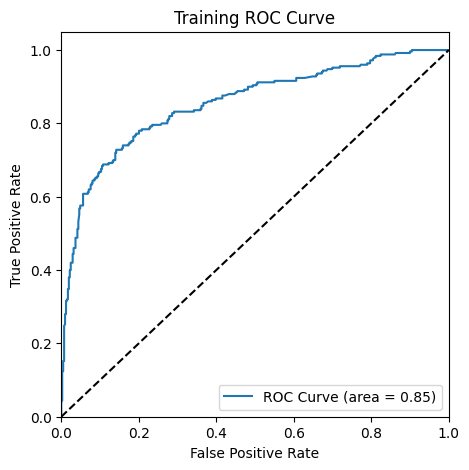

In [ ]:
import matplotlib.pyplot as plt

# Get the ROC curve from the training summary
roc = trainingSummary.roc.toPandas()

# Plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve (area = %0.2f)' % trainingSummary.areaUnderROC)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve')
plt.legend(loc="lower right")
plt.show()
